# <span style="color:#ffe8d6"><b>Olist Data Cleaning Notebook</b></span>
## <span style="color:#e9c46a"><i>Quickly explore, tidy, and prep the Olist dataset for insightful analysis.</i></span>
# 
### <span style="color:#dda15e"><b>Steps:</b></span> <span style="color:#FFA500">Load data</span> • <span style="color:#bc6c25">Visualize nulls</span> • <span style="color:#20B2AA">Initial inspection</span> • <span style="color:#e9c46a">Prep for modeling</span>



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pandas as pd
import numpy as np
from app.utils import preprocessing as pp

data = pp.load_raw_data()
data = pp.rename_columns(data)
data = pp.convert_to_datetime(data)
data = pp.add_date_features(data)


2025-12-03 16:27:38.176 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
"""
Load data
"""

df_customer: pd.DataFrame = data['customer']
df_order: pd.DataFrame = data['order']
df_geo: pd.DataFrame = data['geo']
df_order_item: pd.DataFrame = data['order_item']
df_product: pd.DataFrame = data['product']
df_order_payment: pd.DataFrame = data['order_payment']
df_order_review: pd.DataFrame = data['order_review']
df_seller: pd.DataFrame = data['seller']
df_product_category: pd.DataFrame = data['product_category']

In [3]:
nulls_geo = df_geo.loc[:,(df_geo.isna().sum() > 0).values].columns.tolist()
nulls_orders = df_order.loc[:,(df_order.isna().sum() > 0).values].columns.tolist()
nulls_orders

['approved_timestamp', 'delivered_carrier_date', 'delivered_customer_date']

In [4]:
"""
Check for nulls in each dataset
"""

nulls_geo = df_geo.loc[:,(df_geo.isna().sum() > 0).values].columns.tolist()
nulls_orders = df_order.loc[:,(df_order.isna().sum() > 0).values].columns.tolist()
nulls_order_item = df_order_item.loc[:,(df_order_item.isna().sum() > 0).values].columns.tolist()
nulls_order_payment = df_order_payment.loc[:,(df_order_payment.isna().sum() > 0).values].columns.tolist()
nulls_order_review = df_order_review.loc[:,(df_order_review.isna().sum() > 0).values].columns.tolist()  
nulls_product = df_product.loc[:,(df_product.isna().sum() > 0).values].columns.tolist()
nulls_seller = df_seller.loc[:,(df_seller.isna().sum() > 0).values].columns.tolist()
nulls_product_category = df_product_category.loc[:,(df_product_category.isna().sum() > 0).values].columns.tolist()
nulls_customer = df_customer.loc[:,(df_customer.isna().sum() > 0).values].columns.tolist()


null_cols = []

null_cols.append({"Table": "Geolocation", "Columns": nulls_geo})
null_cols.append({"Table": "Orders", "Columns": nulls_orders})
null_cols.append({"Table": "Order Item", "Columns": nulls_order_item})
null_cols.append({"Table": "Order Payment", "Columns": nulls_order_payment})
null_cols.append({"Table": "Order Review", "Columns": nulls_order_review})
null_cols.append({"Table": "Product", "Columns": nulls_product})
null_cols.append({"Table": "Seller", "Columns": nulls_seller})
null_cols.append({"Table": "Product Category", "Columns": nulls_product_category})
null_cols.append({"Table": "Customer", "Columns": nulls_customer})


[i for i in null_cols if i['Columns']]

[{'Table': 'Orders',
  'Columns': ['approved_timestamp',
   'delivered_carrier_date',
   'delivered_customer_date']},
 {'Table': 'Order Review',
  'Columns': ['review_comment_title', 'review_comment_message']},
 {'Table': 'Product',
  'Columns': ['product_category_name',
   'name_length',
   'description_length',
   'photos_qty',
   'weight',
   'length',
   'height',
   'width']}]

> **Observations:** Nulls found in Orders, Order Review, and Product datasets. 

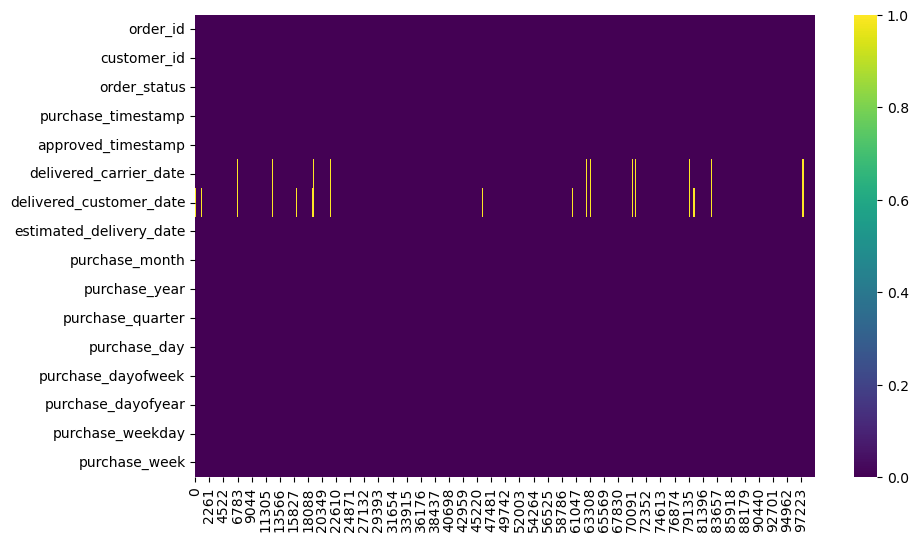

In [5]:
# Show missing values in Orders table
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_order.isna().transpose(), cmap='viridis', ax=ax)
plt.show()

> **Observation:** Missing values cluster around 'order_delivered_customer_date' and 'order_delivered_carrier_date', with some in 'order_approved_at'
>
> **Hypothesis:** Missing values are do to cancellations.
>
> **Next Steps:** Check if there is missing values are found in records with cancelled order status

In [6]:
# Calculate pct of records with missing values and cancelled order status vs pct of records with missing values and not cancelled status

# Whenever customer delivery date is missing, carrier delivery date is missing as well
missing_mask = df_order['delivered_customer_date'].isna()
delivered = df_order['order_status'] == 'delivered'
missing_delivery_delivered = df_order.loc[missing_mask & delivered].copy()
missing_delivery_not_delivered = df_order.loc[missing_mask & ~delivered].copy()

missing_delivery_delivered['delivery_status'] = 'delivered'
missing_delivery_not_delivered['delivery_status'] = 'not delivered'

missing_delivery = pd.concat([missing_delivery_delivered, missing_delivery_not_delivered])
# sns.barplot(x=[missing_delivery_delivered['order_id'].count(), missing_delivery_not_delivered['order_id'].count()], y=['delivered', 'not delivered'])
# plt.show()

chart = alt.Chart(missing_delivery).mark_bar().encode(
    x=alt.X('delivery_status:N', title='Delivery Status', sort='-y'),
    y=alt.Y('count(order_id):Q', title='Count')
).properties(width=300, height=300, title='Count of Null Delivery Dates by Delivery Status')


print("Missing delivery values with delivered status:",f' {len(missing_delivery_delivered)}')
print("Missing delivery values without delivered status",f' {len(missing_delivery_not_delivered)}')

chart


Missing delivery values with delivered status:  8
Missing delivery values without delivered status  2957


alt.Chart(...)

In [7]:
missing_delivery_delivered_pct = len(missing_delivery_delivered) / len(df_order) * 100
missing_delivery_not_delivered_pct = len(missing_delivery_not_delivered) / len(df_order) * 100

print(f'Missing delivery values with delivered status: {missing_delivery_delivered_pct:.2f}% of total orders')
print(f'Missing delivery values without delivered status: {missing_delivery_not_delivered_pct:.2f}% of total orders')

Missing delivery values with delivered status: 0.01% of total orders
Missing delivery values without delivered status: 2.97% of total orders


> **Takeaways:** Only 0.01% of missing values occur in records with 'delivered' status. These are likely due to random error.
>
> **Next Steps:** Determine which delivery status is responsible for the majority of the 2.97% of nulls. 

In [8]:
# All order statuses
df_order["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [9]:
delivered = df_order['order_status'] == 'delivered'
missing_mask = df_order['delivered_customer_date'].isna()

not_delivered = (df_order.loc[missing_mask & ~ delivered]
                    .groupby('order_status')['order_id']
                    .count()
                    .reset_index()
                    .sort_values(by='order_id', ascending=False))
alt.Chart(not_delivered).mark_bar().encode(
        x=alt.X('order_status:N', title='Order Status', sort='-y'),
        y=alt.Y('order_id:Q', title='Count')
    ).properties(width=300, height=300, title='Count of Null Delivery Dates by Order Status').configure_axisX(
        labelAngle=45
    )

alt.Chart(...)

> **Observations:** Majority of missing nulls are due to legitamate reasons, such as shipping, cancelled, invoiced, etc... Some are unexplained with 'unavailable'. 
>
> **Next Steps:** Look into patterns with 'unavailable' order status

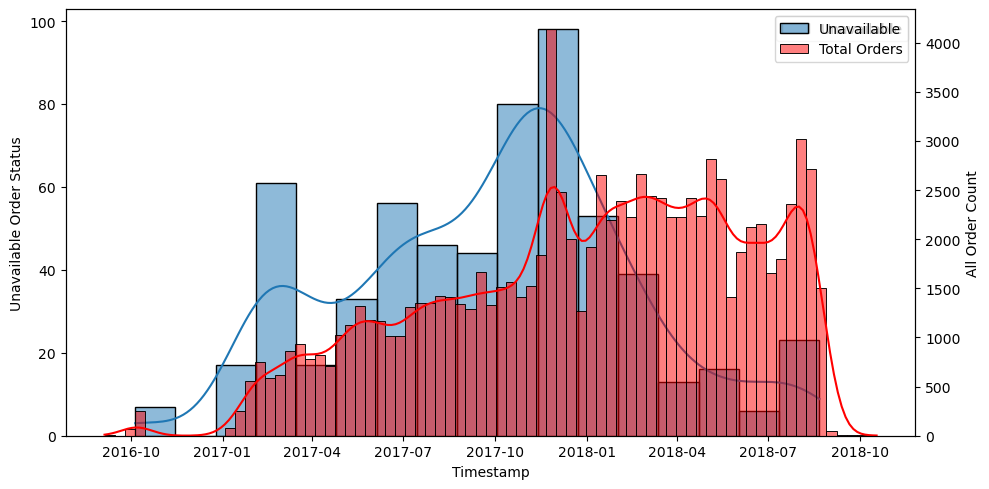

In [10]:
# Filter for only unavailable orders
mask = df_order['order_status'] == 'unavailable'
df_order['purchase_timestamp'] = pd.to_datetime(df_order['purchase_timestamp'])

# Unavailable histogram
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.histplot(df_order.loc[mask], x=df_order.loc[mask, 'purchase_timestamp'], ax=ax1, label='Unavailable', kde=True)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Unavailable Order Status')
ax1.legend()

# Total orders histogram
ax2 = ax1.twinx()
sns.histplot(df_order, x='purchase_timestamp', ax=ax2, kde=True, color="red", label='Total Orders')
ax2.set_xlabel("All orders")
ax2.set_ylabel("All Order Count")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()


> **Observation:** Unavailable order status' follow a similar trend as total orders, indicating that this is due to normal software or human error. 
> 
> **Next Steps:** Impute missing values with 'unavailable' order status.

In [46]:
df_order['delivered_customer_date'] = pd.to_datetime(df_order['delivered_customer_date'])
df_order['delivered_carrier_date'] = pd.to_datetime(df_order['delivered_carrier_date'])

delivery_time = (df_order['delivered_carrier_date'] - df_order['purchase_timestamp']).dt.days

df_order['delivery_time'] = delivery_time
median_delivery_time = df_order['delivery_time'].median()


df_order['delivery_time'] = df_order['delivery_time'].fillna(median_delivery_time)
df_order['delivered_carrier_date'] = df_order['purchase_timestamp'] + pd.to_timedelta(df_order['delivery_time'], unit='D')
df_order['delivered_customer_date'] = df_order['delivered_carrier_date']


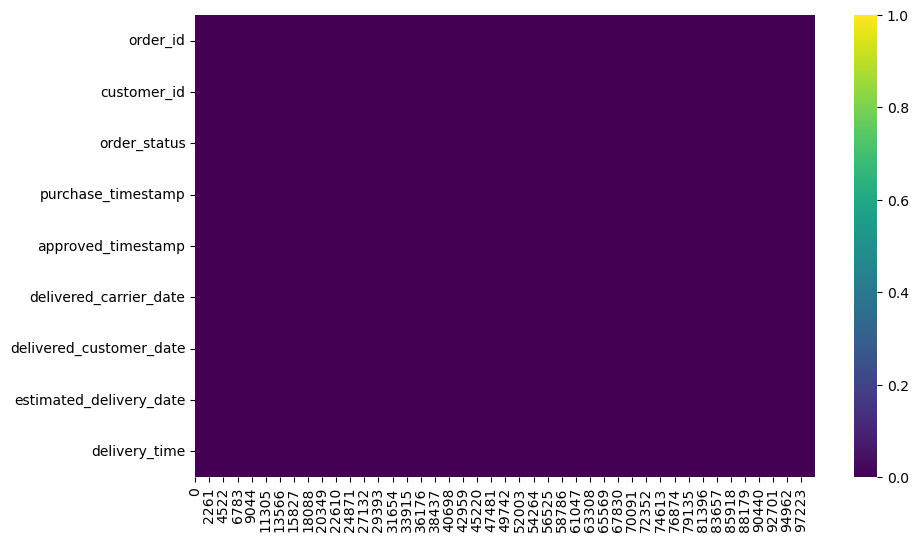

In [47]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_order.isna().transpose(), cmap='viridis', ax=ax)
plt.show()